In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm
import numpy as np
from collections import deque

import matplotlib.pyplot as plt


In [2]:
gamma = 0.99
num_episodes = 1000
MAX_STEPS = 10000
SOLVED_SCORE = 195

In [3]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=1)
        return action_probs

In [4]:
class BaselineNetwork(nn.Module):
    
    def __init__(self, observation_space):
        super(BaselineNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        
        return state_value


In [5]:
def get_action(network, state):
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    action_probs = network(state)
    state = state.detach()
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [6]:
def process_rewards(rewards):
    G = []
    total_r = 0
    for r in reversed(rewards):
        total_r = r + total_r * gamma
        G.insert(0, total_r)
    
    G = torch.tensor(G)
    G = (G - G.mean())/G.std()
    return G


In [7]:
def train_policy(deltas, log_probs, optimizer):
    policy_loss = []
    
    for d, lp in zip(deltas, log_probs):
        policy_loss.append(-d * lp)
    
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()
    

In [8]:
def train_value(G, state_vals, optimizer):
    
    val_loss = F.mse_loss(state_vals, G)
        
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()


In [11]:
def run_rl_baseline(at, ab):

  env = gym.make('CartPole-v1')

  policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
  baseline_network = BaselineNetwork(env.observation_space.shape[0])


  policy_optimizer = optim.Adam(policy_network.parameters(), lr=at)
  baseline_optimizer = optim.Adam(baseline_network.parameters(), lr=ab)

  scores = []

  recent_scores = deque(maxlen=200)

  steps=[]
  actions_ = []

  for episode in tqdm(range(750)):
      
      state = env.reset()
      trajectory = []
      score = 0
      
      for step in range(MAX_STEPS):

          action, lp = get_action(policy_network, state)
          new_state, reward, done, _ = env.step(action)
          score += reward
          trajectory.append([state, action, reward, lp])

          actions_.append(episode+1)
          
          if done:
              steps.append(step+1)
              break
          
          state = new_state
      
      scores.append(score)
      recent_scores.append(score)

      # if len(recent_scores) == 200:
      #   average = sum(recent_scores)/len(recent_scores)
      #   if average >= SOLVED_SCORE:
      #       break
      
      states = [step[0] for step in trajectory]
      actions = [step[1] for step in trajectory]
      rewards = [step[2] for step in trajectory]
      lps = [step[3] for step in trajectory]
      
      G = process_rewards(rewards)
      state_vals = []
      for state in states:
          state = torch.from_numpy(state).float().unsqueeze(0)
          state_vals.append(baseline_network(state))
          
      state_vals = torch.stack(state_vals).squeeze()
      
      train_value(G, state_vals, baseline_optimizer)
          
      deltas = [gt - val for gt, val in zip(G, state_vals)]
      deltas = torch.tensor(deltas)
      
      train_policy(deltas, lps, policy_optimizer)
      

  env.close()

  return scores, actions, steps


In [14]:
alpha_thetas = [ 0.01, 0.005, 0.001, 0.0005]
alpha_ws = [0.01, 0.005, 0.001, 0.0005]

total_scores = []
total_actions = []
total_steps = []
for alpha_theta in alpha_thetas:
  for alpha_w in alpha_ws:
    scores = []
    actions = []
    steps = []
    for i in range(5):
      s, a, s_ = run_rl_baseline(alpha_theta, alpha_w)
      scores.append(s)
      actions.append(a)
      steps.append(s_)
    total_scores.append(scores)
    total_actions.append(actions)
    total_steps.append(steps)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 750/750 [02:14<00:00,  5.56it/s]


In [15]:
total_rewards = np.array(total_scores)
total_steps = np.array(total_steps)
total_actions = np.array(total_actions)
total_rewards.shape, total_actions.shape, total_steps.shape

<ipython-input-15-4c22c23078b1>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_actions = np.array(total_actions)


((16, 5, 750), (16, 5), (16, 5, 750))

In [16]:
total_steps_ = total_steps.mean(axis=1).mean(axis=1).reshape((4, 4))

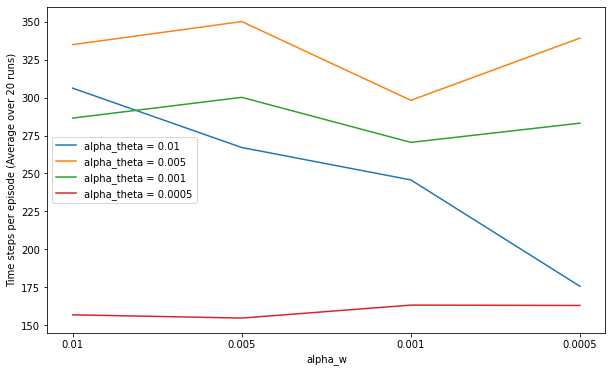

In [17]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(4):
  plt.plot(list(range(4)), total_steps_[i], label = "alpha_theta = "+str(alpha_thetas[i]))
plt.xticks(list(range(4)), alpha_ws)
plt.xlabel('alpha_w')
plt.ylabel('Time steps per episode (Average over 20 runs)')
plt.legend()
plt.show()

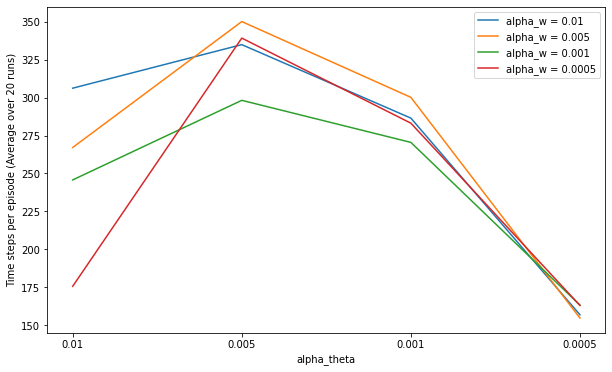

In [18]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(4):
  plt.plot(list(range(4)), total_steps_.T[i], label = "alpha_w = "+str(alpha_ws[i]))
plt.xticks(list(range(4)), alpha_thetas)
plt.xlabel('alpha_theta')
plt.ylabel('Time steps per episode (Average over 20 runs)')
plt.legend()
plt.show()

In [19]:
total_rewards.shape

(16, 5, 750)

In [24]:
average_reward_aw_0_025 = total_rewards.reshape((4, 4, 5, 750)).transpose((1,0,2, 3))

463.6


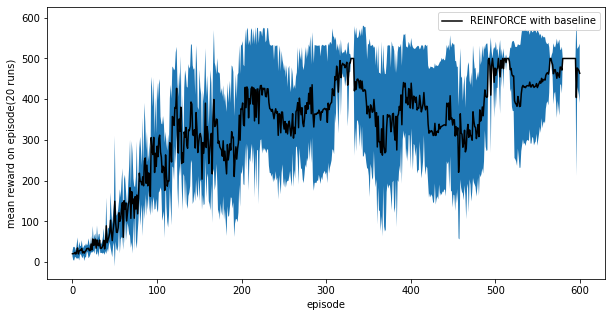

In [30]:
plt.rcParams['figure.figsize'] = (10, 5)
num_episodes = 600

x = np.linspace(0,  600, 600)
y = average_reward_aw_0_025[1, 1, :, :600].mean(axis=0)
error = average_reward_aw_0_025[1, 1, :, :600].std(axis=0)
print(y[-1])

plt.plot(x, y, '-k', label = 'REINFORCE with baseline')
plt.fill_between(x, y-error, y+error)

plt.ylabel('mean reward on episode(20 runs)')
plt.xlabel('episode')
plt.legend()
plt.show()

In [ ]:
main_temp = []
for i in range(4):
  temp = []
  for each in total_actions[i, :]:
    print(len(each))
    temp.append(each[:77854])
  temp = np.array(temp).mean(axis=0)
  
  main_temp.append(temp)

179014
199145
77854
302307
265979
211214
211607
221251
221866
109957
107885
122458


In [ ]:
np.array(main_temp).shape

(4, 77854)

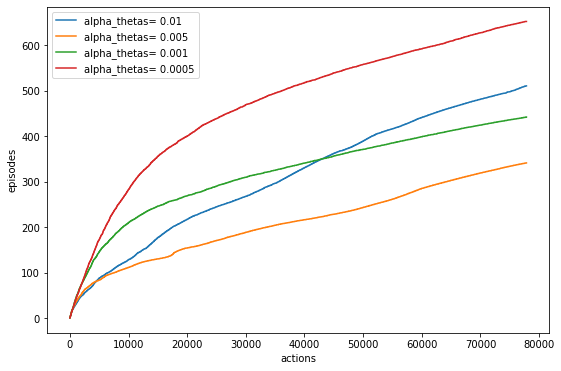

In [ ]:
plt.rcParams['figure.figsize'] = (9, 6)
for i in range(4):
  plt.plot(list(range(77854)), np.array(main_temp)[i], label = "alpha_thetas= "+str(alpha_thetas[i]))
plt.xlabel('actions')
plt.ylabel('episodes')
plt.legend()
plt.show()

In [ ]:
main_temp = []
for i in range(4):
  temp = []
  for each in total_actions[i, :]:
    print(len(each))
    temp.append(each[:179154])
  temp = np.array(temp).mean(axis=0)
  
  main_temp.append(temp)

208806
201696
203168
221139
198225
213281
204712
210878
211686
200696
179154
206586


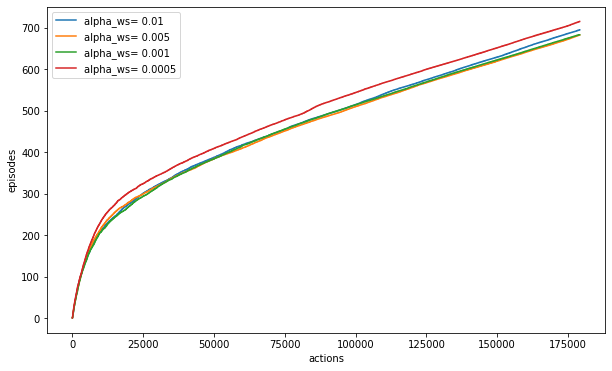

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6)
for i in range(4):
  plt.plot(list(range(179154)), np.array(main_temp)[i], label = "alpha_ws= "+str(alpha_ws[i]))
plt.xlabel('actions')
plt.ylabel('episodes')
plt.legend()
plt.show()

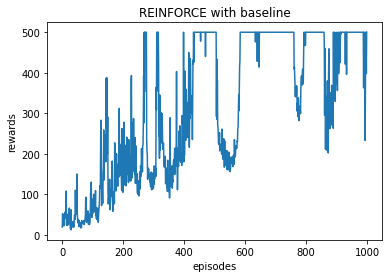

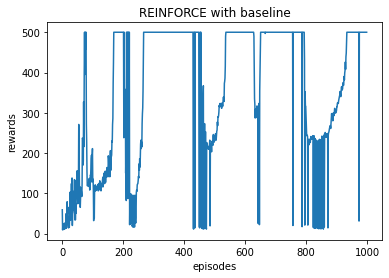

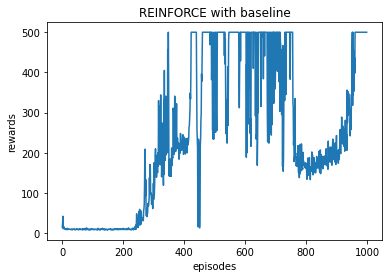

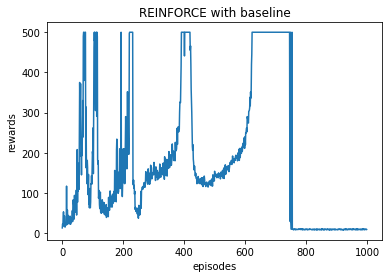

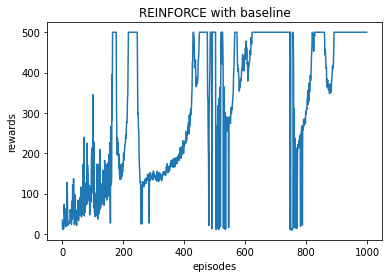

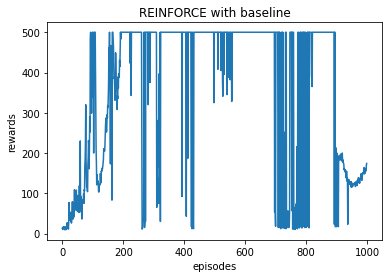

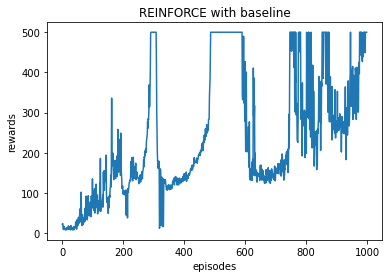

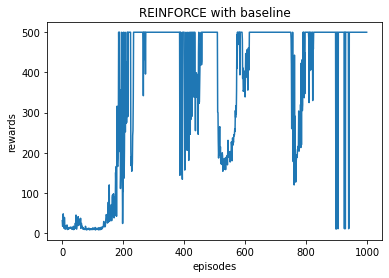

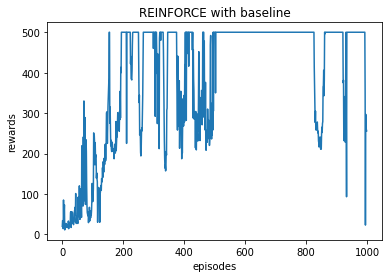

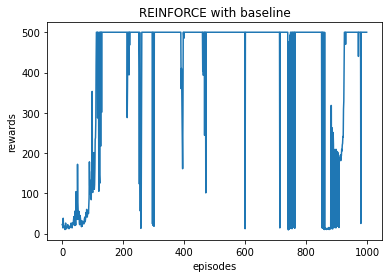

IndexError: ignored

In [ ]:
for i in range(20):
  plt.plot(np.array(scores[i]))
  plt.ylabel('rewards')
  plt.xlabel('episodes')
  plt.title('REINFORCE with baseline')
  plt.show()

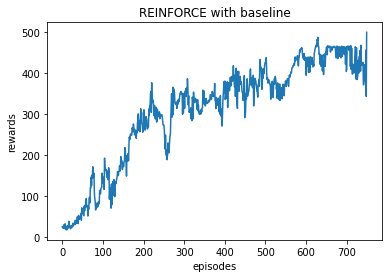

In [ ]:
plt.plot(np.array(scores)[:, :750].mean(axis=0))
plt.ylabel('rewards')
plt.xlabel('episodes')
plt.title('REINFORCE with baseline')
plt.show()

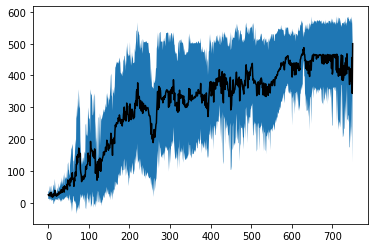

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(0, 750, 750)
y = np.array(scores)[:, :750].mean(axis=0)
error = np.array(scores)[:, :750].std(axis=0)

plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.show()

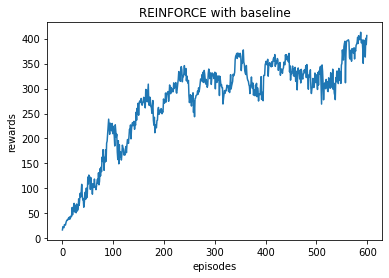

In [ ]:
plt.plot(np.array(scores).mean(axis=0))
plt.ylabel('rewards')
plt.xlabel('episodes')
plt.title('REINFORCE with baseline')
plt.show()

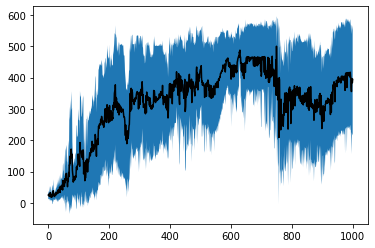

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(0, 1000, 1000)
y = np.array(scores).mean(axis=0)
error = np.array(scores).std(axis=0)

plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.show()